In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Importing all the libraries 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
import cv2

import warnings
warnings.filterwarnings('ignore')

# **Loading the Data**

In [3]:
# Define path to the data directory
dir_alldata = Path('/content/drive/MyDrive/Pneumonia Chest X-ray/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_data_dir = dir_alldata / 'train'

# Path to validation directory
validation_data_dir = dir_alldata / 'val'

# Path to test directory
test_data_dir = dir_alldata / 'test'

# Get the path to the normal and pneumonia sub-directories
normal_cases_train = train_data_dir / 'NORMAL'
pneumonia_cases_train = train_data_dir / 'PNEUMONIA'

In [4]:
img_width, img_height = 150,150
nb_train_sample =1000
nb_validation_samples =100

epochs = 50
batch_size = 20

if K.image_data_format()=="channels_first":
    input_shape =(3,img_width, img_height)
else:
    input_shape =(img_width, img_height,3)

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator= train_datagen.flow_from_directory(train_data_dir, target_size =(150,150),batch_size=batch_size, class_mode="binary" )

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")

test_generator = test_datagen.flow_from_directory(test_data_dir, target_size = (150,150),batch_size=batch_size, class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


About The Data:
* Data Consists of 2 categories. Pnuemonia and Normal
* There are 5863 X-ray images
* Pnuemonia has 2 categories. Bacterial and Viral Pnuemonia



# **Data Visualization**
Steps involved in visualisation:

* Plotting Random Normal Images
* Plotting Random Pneumonia Images
* Plotting Count of Positive and Negative Cases

Printing three Normal random images 
IM-0099-0001.jpeg
NORMAL2-IM-0294-0001.jpeg
IM-0033-0001-0002.jpeg


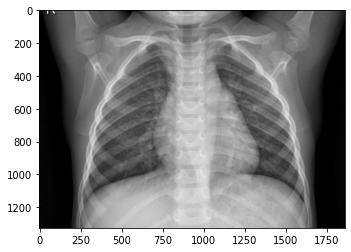

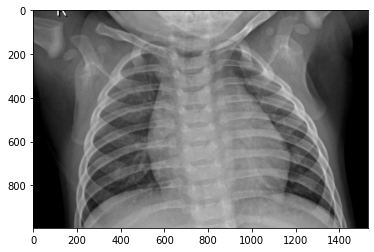

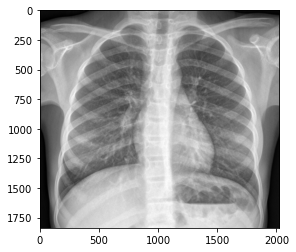

In [5]:
# Three Random Normal CXR Images from the dataset
import os, random

folder_N=r'/content/drive/MyDrive/Pneumonia Chest X-ray/chest_xray/chest_xray/test/NORMAL'

a=random.choice(os.listdir(folder_N))
b=random.choice(os.listdir(folder_N))
c=random.choice(os.listdir(folder_N))
print("Printing three Normal random images ")
print(a)
print(b)
print(c)

random_N = [a, b, c]

for i in random_N:
    file = folder_N+'/'+i
    img = image.load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.show() 

Printing three PNEUMONIA random images
person101_bacteria_483.jpeg
person1640_virus_2839.jpeg
person137_bacteria_655.jpeg


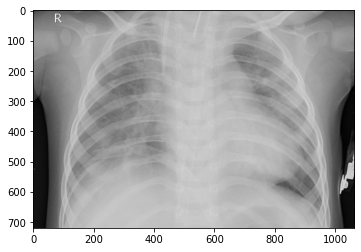

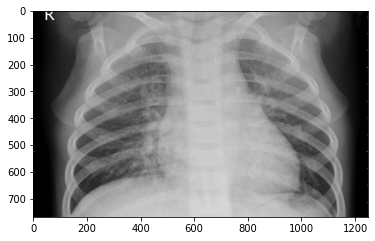

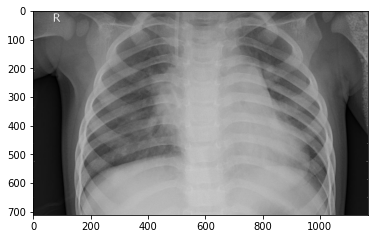

In [6]:
# Three Random Normal CXR Images from the dataset
import os, random

folder_N=r'/content/drive/MyDrive/Pneumonia Chest X-ray/chest_xray/chest_xray/test/PNEUMONIA'

a=random.choice(os.listdir(folder_N))
b=random.choice(os.listdir(folder_N))
c=random.choice(os.listdir(folder_N))
print("Printing three PNEUMONIA random images")
print(a)
print(b)
print(c)

random_N = [a, b, c]

for i in random_N:
    file = folder_N+'/'+i
    img = image.load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.show() 

The dataset is labelled by a medical professional. It is not decipherable for a layman. However, it seems like the sharpness around the diaphragm could be the deciding factor. Nonetheless, there have been exceptions in that case as well. So this diagnosis is a subjective matter. Let's leave it to the Convnet to figure that out.

** Next, we will have a look at the count of classes. **

**The Count of Classes**

Text(0.5, 1.0, 'Count of Positive (0) and Negative Cases (1)')

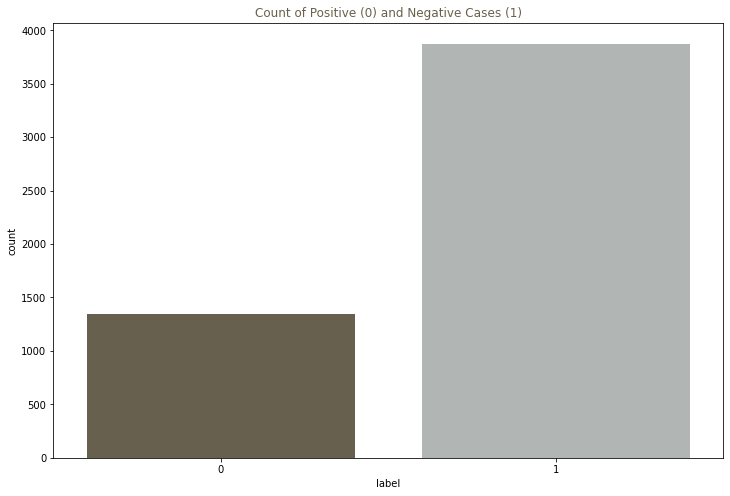

In [9]:
# To plot the count plot I am changing the dataset into a pandas dataframe
# Get the list of all the images
normal = normal_cases_train.glob('*.jpeg')
pneumonia = pneumonia_cases_train.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal:
    train_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia:
    train_df.append((img,1))

# Get a pandas dataframe from the data we have in our list 
train_df = pd.DataFrame(train_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
plt.figure(figsize=(12,8))
count = sns.countplot(train_df["label"], palette=["#6B614B","#B0B7B5"])
count.set_title("Count of Positive (0) and Negative Cases (1)", color="#6B614B")

There is a data imbalance. The number of Pneumonia CXR images are more than the number of normal CXR images.

# **Model Building**
In this project, we build an Convolutional neural network.

Following steps are involved in the model building

* Initialising the Convnet
* Defining by adding layers
* Compiling the Convnet
* Train the Convnet

In [10]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [11]:
model.compile(loss= "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
history = model.fit_generator(train_generator, steps_per_epoch=nb_train_sample//batch_size, epochs=epochs,validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
50/50 [==============================] - 173s 3s/step - loss: 0.5895 - accuracy: 0.7300 - val_loss: 0.9387 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 137s 3s/step - loss: 0.3944 - accuracy: 0.8070
Epoch 3/50
50/50 [==============================] - 117s 2s/step - loss: 0.3355 - accuracy: 0.8444
Epoch 4/50
50/50 [==============================] - 111s 2s/step - loss: 0.3186 - accuracy: 0.8570
Epoch 5/50
50/50 [==============================] - 97s 2s/step - loss: 0.2812 - accuracy: 0.8790
Epoch 6/50
50/50 [==============================] - 78s 2s/step - loss: 0.2884 - accuracy: 0.8850
Epoch 7/50
50/50 [==============================] - 72s 1s/step - loss: 0.3165 - accuracy: 0.8700
Epoch 8/50
50/50 [==============================] - 67s 1s/step - loss: 0.2736 - accuracy: 0.8990
Epoch 9/50
50/50 [==============================] - 58s 1s/step - loss: 0.2633 - accuracy: 0.8920
Epoch 10/50
50/50 [==============================] - 56s 1s/step - loss:

# **Conclusion**
Concluding the model with:

* Testing on the test set
* Evaluating Test Accuracy

In [14]:
test_accuracy = model.evaluate_generator(test_generator)

In [15]:
print('The accuracy on test set :',test_accuracy[1]*100 )

The accuracy on test set : 88.62179517745972
